In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install accuracy

  Using cached accuracy-0.1.1-py2.py3-none-any.whl (7.8 kB)
  Using cached spacy-3.4.1-cp38-cp38-win_amd64.whl (12.1 MB)
  Using cached scikit_learn-1.1.2-cp38-cp38-win_amd64.whl (7.3 MB)
  Using cached clumper-0.2.15-py2.py3-none-any.whl (18 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached rich-12.5.1-py3-none-any.whl (235 kB)
  Using cached altair-4.2.0-py3-none-any.whl (812 kB)
  Using cached commonmark-0.9.1-py2.py3-none-any.whl (51 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached thinc-8.1.0-cp38-cp38-win_amd64.whl (1.3 MB)
  Using cached pathy-0.6.2-py3-none-any.whl (42 kB)
  Using cached spacy_loggers-1.0.3-py3-none-any.whl (9.3 kB)
  Using cached spacy_legacy-3.0.10-py2.py3-none-any.whl (21 kB)
  Using cached blis-0.7.8-cp38-cp38-win_amd64.whl (6.6 MB)
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
  Attempting uninstall:

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\~klearn\\datasets\\_svmlight_format_fast.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [19]:
# The collected data is the sentiments from twitter for President Rodrigo R. Duterte's administration.

# Train data has 1600 rows
train = pd.read_csv("train.csv")

# 320 Test data
test = pd.read_csv("test.csv")

In [15]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


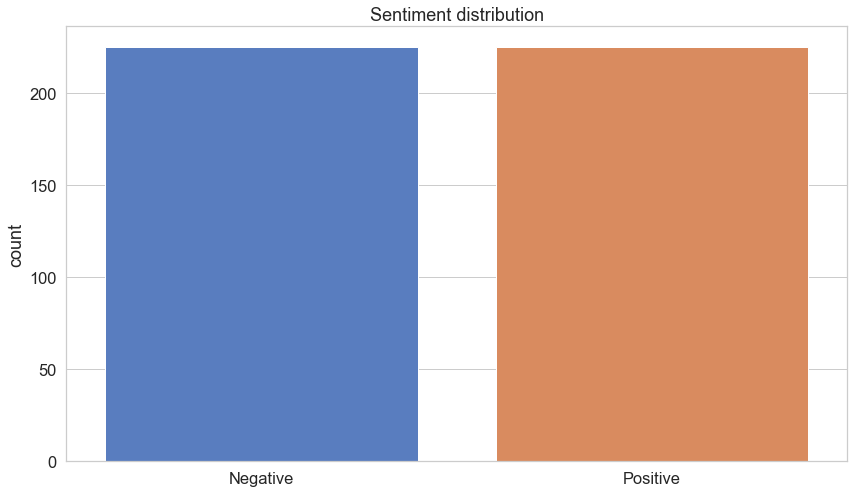

In [20]:
f = sns.countplot(x='sentiment', data=train)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

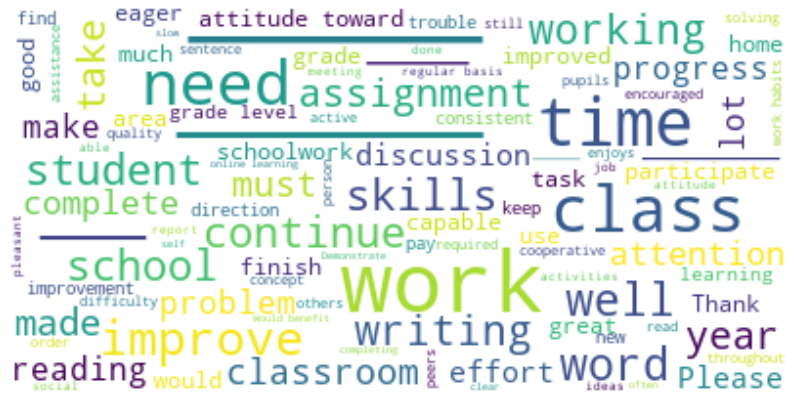

In [17]:
text = " ".join(remarks for remarks in train.remarks)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [21]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [22]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [23]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [25]:
X = train['remarks'].values
y = train['sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [26]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [27]:
y_hat = MNB.predict(X_test)

In [28]:
accuracy_score(y_test, y_hat)

0.7333333333333333

In [29]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.86      0.76        43
           1       0.83      0.62      0.71        47

    accuracy                           0.73        90
   macro avg       0.75      0.74      0.73        90
weighted avg       0.75      0.73      0.73        90



In [30]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[37,  6],
       [18, 29]], dtype=int64)

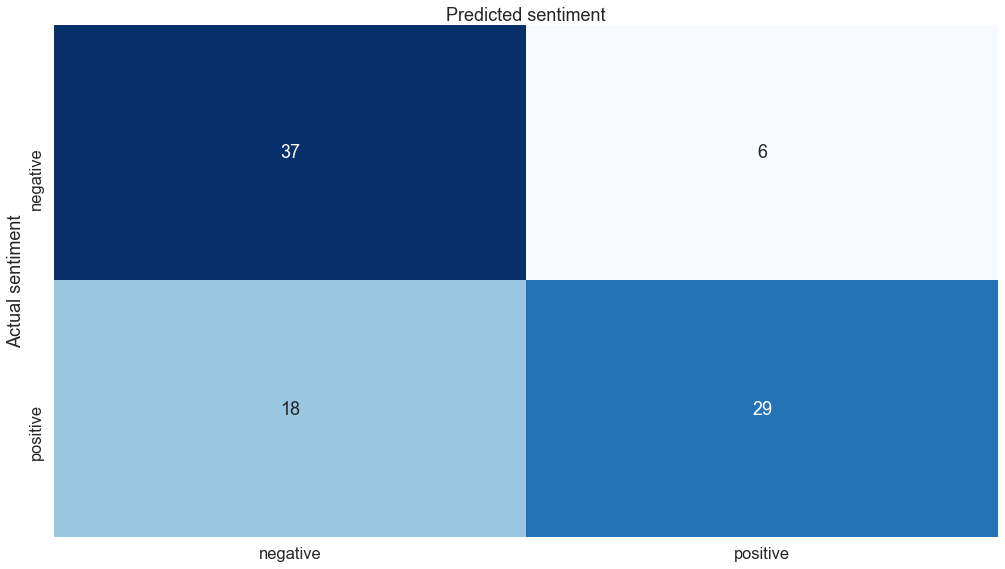

In [31]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');